### Imports

In [17]:
# IMPORTS
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import resample
import statsmodels.stats.proportion as proportion
from scipy import stats
import scipy.stats as st 
import seaborn as sns
# Custom utils functions
import sys; sys.path.append("./libraries/")
from utils import *


### Settings


In [18]:
# Relative Paths
RAW_DATA = "../data/raw/"
PROC_DATA = "../data/processed/"

# Flags
process = False

### Load Data

In [19]:
# If process, load raw data and apply matching between datasets 
# NOTE: It may take several minutes
if process:
    # Raw player's datasets
    players = pd.read_csv('https://query.data.world/s/gksm6hx4xzgjaed7tia2uzpafwvyjo?dws=00000')
    ratings22 = pd.read_csv(RAW_DATA + "FIFA22_player_ratings.csv") # FIFA player attributes from 2022
    ratings21 = pd.read_csv(RAW_DATA + "FIFA21_player_ratings.csv") # FIFA player attributes from 2022
    # This appends players from 2021 not present in 2022
    extended = set(ratings21.sofifa_id).difference(set(ratings22.sofifa_id))
    FIFA = pd.concat([ratings22, ratings21[ratings21.sofifa_id.isin(extended)]]).reset_index()

    # Remove uninformative columns
    players.drop(["player_code", "agent_name", "image_url", "url"], axis=1, inplace=True)
    FIFA.drop(["player_url", "club_team_id", "club_position", "club_jersey_number", "club_loaned_from", "club_joined", 
                "nationality_id", "nation_team_id", "nation_jersey_number", "real_face", "player_tags", "player_face_url", 
                "club_logo_url", "club_flag_url", "nation_logo_url", "nation_flag_url"], axis=1, inplace=True)
    
    # Find matches using custom function
    longname_matches = match_players(players, FIFA)
    # Append the extracted FIFA long names
    players["FIFA_long_name"] = longname_matches

    ## Merge players with FIFA attributes
    # Create a unique identifier with long name and year of birth
    players["fifa_id"] = players["FIFA_long_name"] + "-" + pd.to_datetime(players["date_of_birth"]).dt.year.astype(str)
    FIFA["fifa_id"] = FIFA.long_name + "-" + pd.to_datetime(FIFA["dob"]).dt.year.astype(str)
    # Join
    players = players.merge(FIFA, on="fifa_id", how="inner")
    # Drop temp id cols
    players.drop(["name", "fifa_id", "sofifa_id"], axis=1, inplace=True)
    # Save dataset
    players.to_csv(PROC_DATA + "players_wFIFAattributes.csv", index=False)

# Else load processed data
else:
    players = pd.read_csv(PROC_DATA + "players_wFIFAattributes.csv")

# Get valuation data
valuations = pd.read_csv('https://query.data.world/s/y4qg2twfvou4w2ghz6o3evju32g7yn?dws=00000') 
# ... (we can get some more datasets if needed)

# See data
print(players.info())
players.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11159 entries, 0 to 11158
Columns: 112 entries, player_id to gk
dtypes: float64(15), int64(44), object(53)
memory usage: 9.5+ MB
None


,player_id,first_name,last_name,FIFA_long_name,last_season,country_of_birth,city_of_birth,country_of_citizenship,date_of_birth,sub_position,...,ldm,cdm,rdm,rwb,lb,lcb,cb,rcb,rb,gk
0,3875,Jermain,Defoe,Jermain Colin Defoe,2021,England,London,England,1982-10-07,Centre-Forward,...,43+2,43+2,43+2,43+2,40+2,38+2,38+2,38+2,40+2,18+2
1,4742,Christophe,Lepoint,Christophe Lepoint,2022,Belgium,Brussel,Belgium,1984-10-24,Central Midfield,...,68-1,68-1,68-1,62+2,62+2,67,67,67,62+2,16+2
2,6838,Henok,Goitom,Henok Goitom,2015,Sweden,Solna,Eritrea,1984-09-22,Centre-Forward,...,55+2,55+2,55+2,50+2,48+2,50+2,50+2,50+2,48+2,17+2
3,10003,Wes,Morgan,Wes Morgan,2020,England,Nottingham,Jamaica,1984-01-21,Centre-Back,...,64+2,64+2,64+2,54+2,57+2,73,73,73,57+2,16+2
4,10471,NaN,Luiz Gustavo,Luiz Gustavo Dias,2021,Brazil,Pindamonhangaba,Brazil,1987-07-23,Defensive Midfield,...,75+2,75+2,75+2,71+3,71+3,75+2,75+2,75+2,71+3,17+3


### EDA

In [20]:
players.describe()
valuations.describe()

,player_id,last_season,market_value_in_eur,n,current_club_id
count,4.243230e+05,424323.000000,4.243230e+05,424323.0,424323.000000
mean,1.867438e+05,2018.291179,2.349103e+06,1.0,3869.573763
std,1.693496e+05,3.302729,6.557607e+06,0.0,9032.284990
min,1.000000e+01,2012.000000,1.000000e+04,1.0,3.000000
25%,5.330600e+04,2016.000000,2.000000e+05,1.0,367.000000
50%,1.324070e+05,2019.000000,5.000000e+05,1.0,1003.000000
75%,2.792150e+05,2021.000000,1.600000e+06,1.0,2921.000000
max,1.112706e+06,2022.000000,2.000000e+08,1.0,83678.000000


In [21]:
players_columns = players.columns
valuations_columns = valuations.columns
valuations_columns

Index(['player_id', 'last_season', 'datetime', 'date', 'dateweek',
       'market_value_in_eur', 'n', 'current_club_id',
       'player_club_domestic_competition_id'],
      dtype='object')

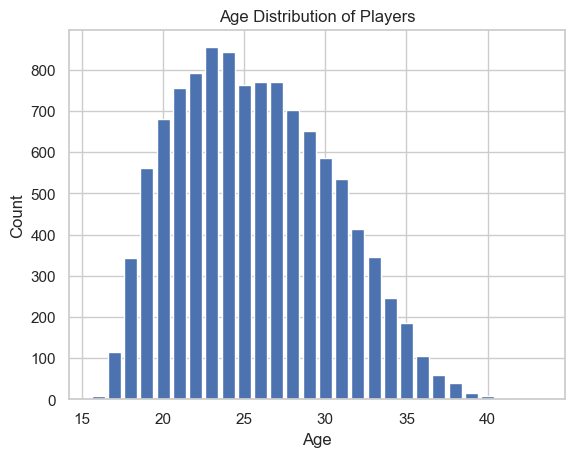

In [22]:
### Plotting the age distribution

age_distribution = players['age'].value_counts()

# Plotting
plt.bar(age_distribution.index, age_distribution.values)

plt.xlabel('Age')
plt.ylabel('Count')
plt.title('Age Distribution of Players')
plt.show()

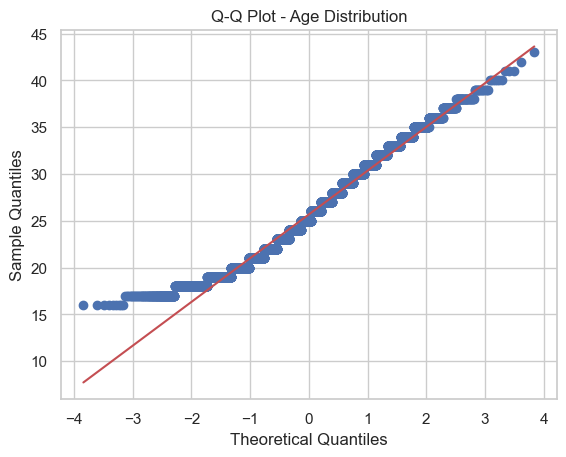

In [23]:
#### checking if the age distribution follows a normal distribution

age_distribution_qq = players['age'].values

# Create the Q-Q plot
stats.probplot(age_distribution_qq, dist="norm", plot=plt)
plt.title('Q-Q Plot - Age Distribution')
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Sample Quantiles')
plt.show()

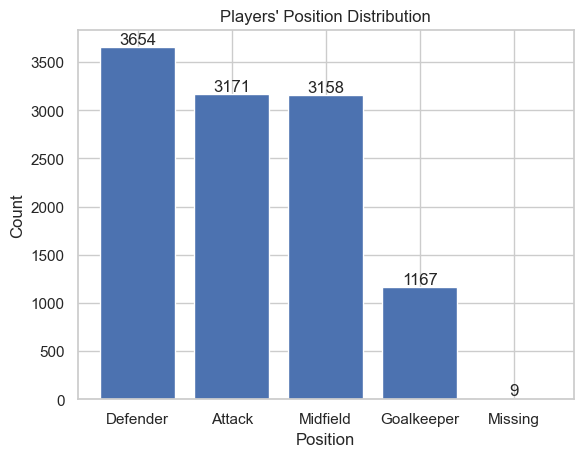

In [24]:

### Player Positions
players_positions = players['position'].value_counts()

# Plotting
fig, ax = plt.subplots()
bars = ax.bar(players_positions.index, players_positions.values)

# Add counts on top of the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, int(yval), va='bottom', ha='center')

plt.xlabel('Position')
plt.ylabel('Count')
plt.title("Players' Position Distribution")
plt.show()


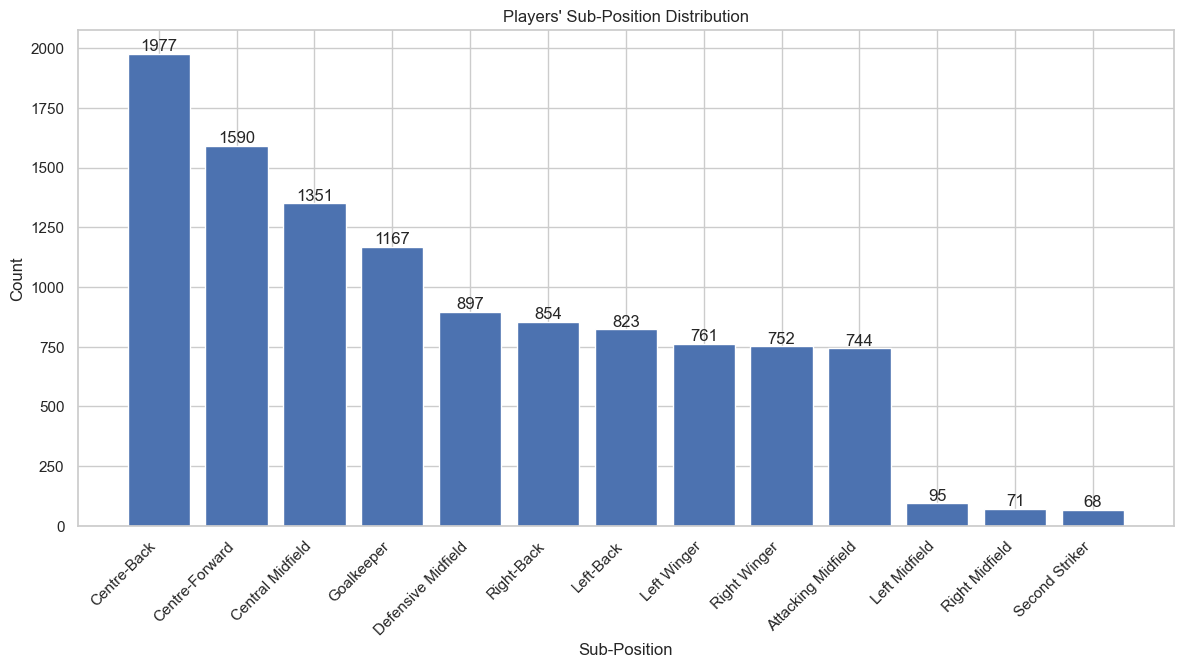

In [25]:

players_sub_positions = players['sub_position'].value_counts()

# Plotting
fig, ax = plt.subplots(figsize=(12, 6))
bars = ax.bar(players_sub_positions.index, players_sub_positions.values)

# Add counts on top of the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval, int(yval), va='bottom', ha='center')


plt.xlabel('Sub-Position')
plt.ylabel('Count')
plt.title("Players' Sub-Position Distribution")
plt.tight_layout() 
plt.xticks(rotation=45, ha='right')
plt.show()


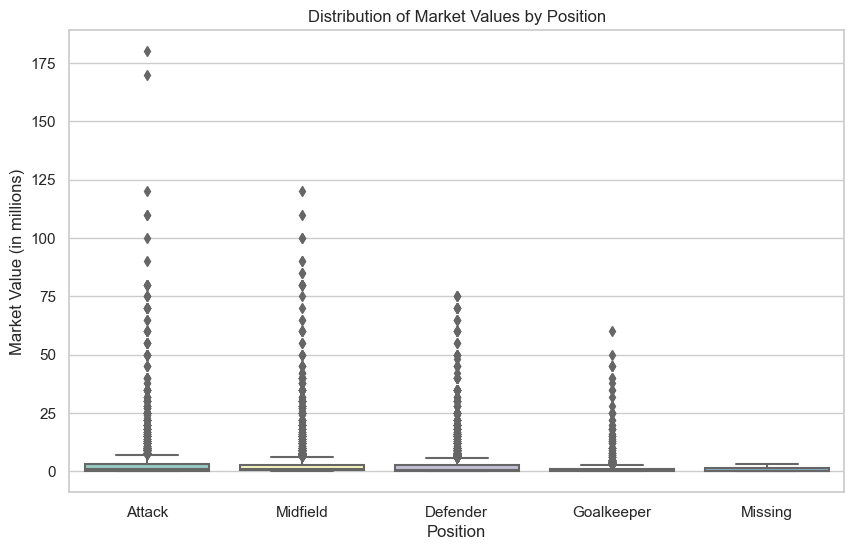

In [26]:
players['scaled_market_value'] = players['market_value_in_eur'] / 1e6  # Scaling by dividing by 1 million

sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.boxplot(x='position', y='scaled_market_value', data=players, palette='Set3')

plt.xlabel('Position')
plt.ylabel('Market Value (in millions)')
plt.title('Distribution of Market Values by Position')

# Show the plot
plt.show()

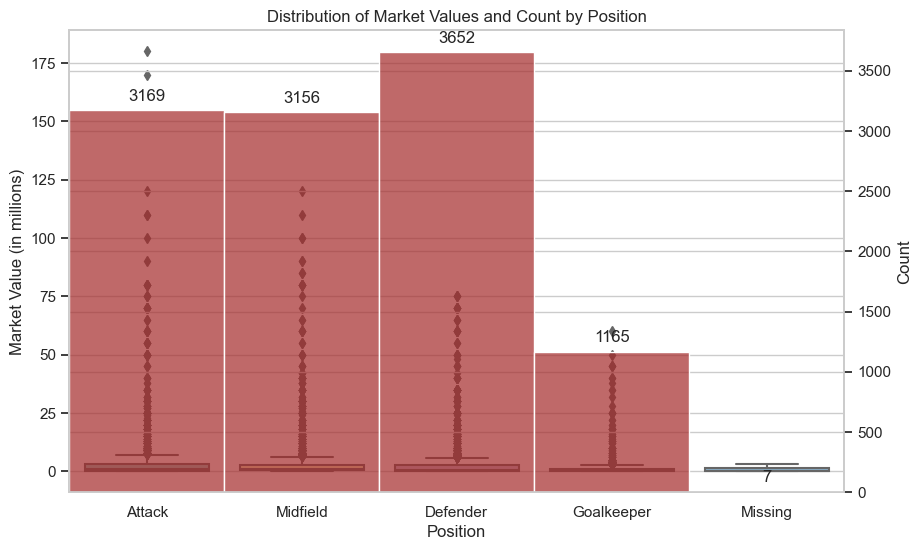

In [27]:

sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))

# Box plot for scaled market values
ax1 = sns.boxplot(x='position', y='scaled_market_value', data=players, palette='Set3')
ax1.set_xlabel('Position')
ax1.set_ylabel('Market Value (in millions)')

# Create a second y-axis for the histogram
ax2 = ax1.twinx()

# Histogram for each position on top
sns.histplot(x='position', data=players, ax=ax2, color='brown', alpha=0.7)
ax2.set_ylabel('Count')
for p in ax2.patches:
    ax2.annotate(f'{int(p.get_height() - 2)}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')


plt.title('Distribution of Market Values and Count by Position')

# Show the plot
plt.show()


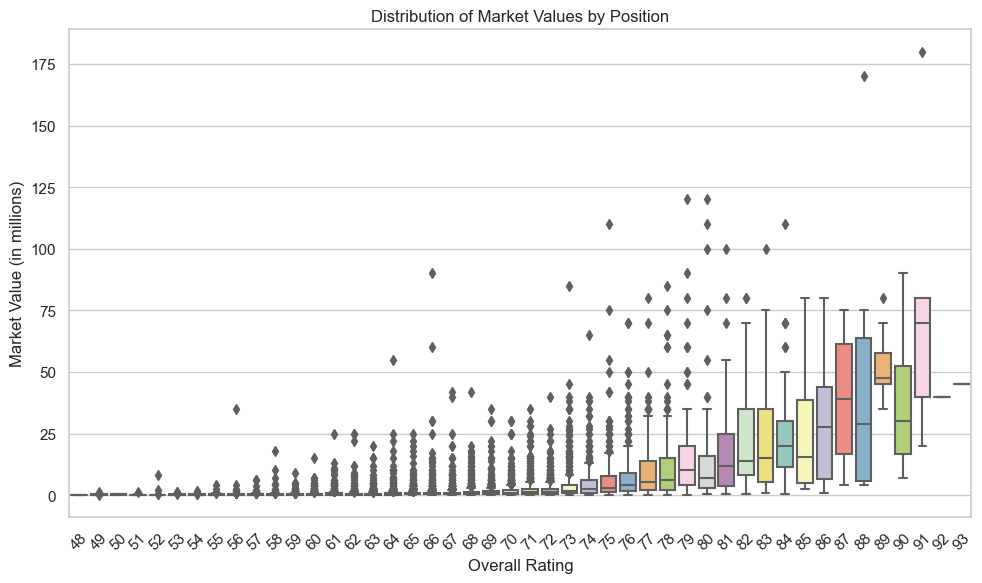

In [28]:
overall = players['overall'].value_counts()
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.boxplot(x='overall', y='scaled_market_value', data=players, palette='Set3')

plt.xlabel('Overall Rating')
plt.ylabel('Market Value (in millions)')
plt.title('Distribution of Market Values by Position')
plt.xticks(rotation = 45)
plt.tight_layout()

# Show the plot
plt.show()

### Enough EDA


In [29]:
import statsmodels.api as sm
import numpy as np
### bernoulli experiment with confidence intervals

age_count = dict(age_distribution)
# Specify the age of interest
age_of_interest = 24

# Number of occurrences of the age of interest
successes = age_distribution.get(age_of_interest, 0)

# Total number of trials
total_trials = sum(age_count.values())

# Calculate the proportion
proportion = successes / total_trials

# Calculate the confidence interval
conf_interval = sm.stats.proportion_confint(successes, total_trials, alpha=0.05, method='beta')

# Print the results
print(f"Proportion for age {age_of_interest}: {proportion:.4f}")
print(f"Confidence Interval: ({conf_interval[0]:.4f}, {conf_interval[1]:.4f})")


Proportion for age 24: 0.0755
Confidence Interval: (0.0707, 0.0806)


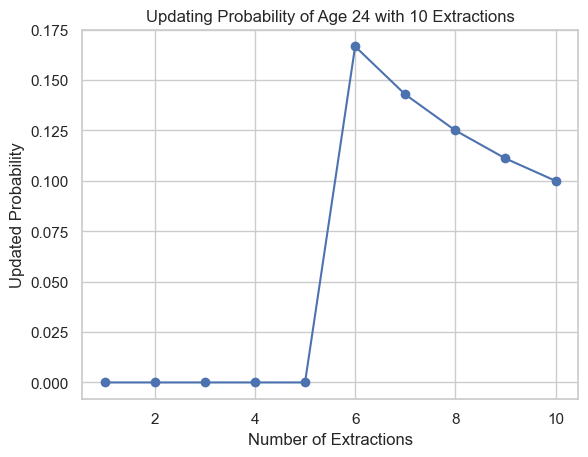

In [30]:

# Example age distribution (replace this with your actual data)

# Number of players to extract
num_extractions = 10

# Initialize variables
selected_ages = []
probabilities = []

for _ in range(num_extractions):
    # Randomly select an age with replacement
    selected_age = np.random.choice(list(age_count.keys()), p=list(age_count.values()) / sum(age_count.values()))
    selected_ages.append(selected_age)
    
    # Update the age distribution (if extracting without replacement)
    age_count[selected_age] -= 1
    
    # Calculate the updated probability
    successes = selected_ages.count(age_of_interest)
    total_trials = len(selected_ages)
    probability = successes / total_trials
    probabilities.append(probability)

# Plot the results
plt.plot(range(1, num_extractions + 1), probabilities, marker='o')
plt.xlabel('Number of Extractions')
plt.ylabel('Updated Probability')
plt.title(f'Updating Probability of Age {age_of_interest} with {num_extractions} Extractions')
plt.show()


### Jacknife for Mean

In [31]:
### reconstructing the dataframe 
data = []
for age, count in age_distribution.items():
    data.extend([age] * count)

### calculating the mean of the population
initial_statistic = np.mean(data)



In [32]:
jackknife_samples = [round(np.mean([age for age in data if age != left_out_age]), 5) 
                     for left_out_age in set(data)]


n = len(set(data))  # Number of unique ages
mean_jackknife_samples = np.mean(jackknife_samples)
variance = (n - 1) / n * np.sum((jackknife_samples - mean_jackknife_samples) ** 2)
standard_error = np.sqrt(variance)
ci_lower = initial_statistic - 1.96 * standard_error
ci_upper = initial_statistic + 1.96 * standard_error




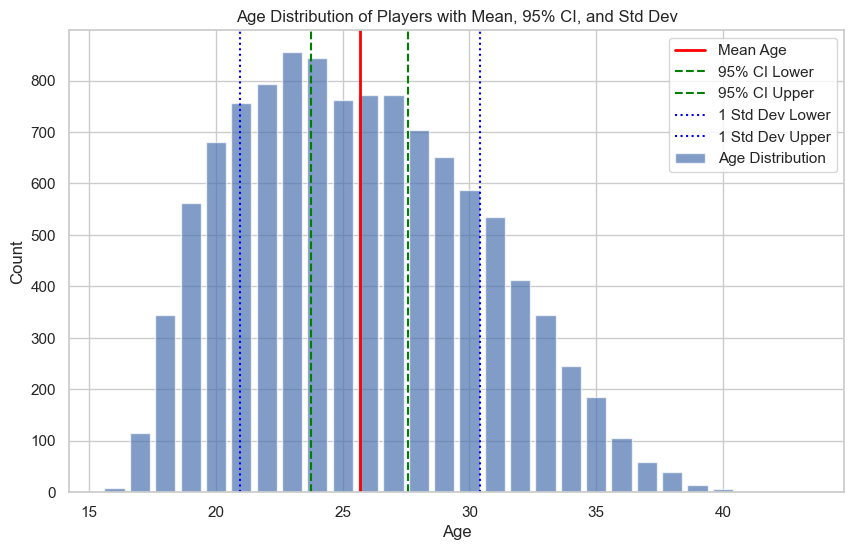

Mean is: 25.67452280670311 ; Confidence interval for the mean is: 23.75965347886791 27.589392134538308


In [33]:

age_distribution = players['age'].value_counts().sort_index()

# Calculating mean, CI, and standard deviation
mean_age = np.mean(players['age'])
std_dev_age = np.std(players['age'])

plt.figure(figsize=(10, 6))
plt.bar(age_distribution.index, age_distribution.values, alpha=0.7, label='Age Distribution')

# Add mean and CI
plt.axvline(x=mean_age, color='red', linestyle='-', linewidth=2, label='Mean Age')
plt.axvline(x=ci_lower, color='green', linestyle='--', label='95% CI Lower')
plt.axvline(x=ci_upper, color='green', linestyle='--', label='95% CI Upper')

# Add standard deviation
plt.axvline(x=mean_age - std_dev_age, color='blue', linestyle=':', label='1 Std Dev Lower')
plt.axvline(x=mean_age + std_dev_age, color='blue', linestyle=':', label='1 Std Dev Upper')

# Labels and title
plt.xlabel('Age')
plt.ylabel('Count')
plt.title('Age Distribution of Players with Mean, 95% CI, and Std Dev')
plt.legend()
plt.show()
print('Mean is:', mean_age, ";",'Confidence interval for the mean is:', ci_lower, ci_upper)

In [34]:

### Jacknife for age ranges
initial_range = np.max(data) - np.min(data)
n = len(data)

# Create jackknife samples and calculate their ranges
jackknife_ranges = [np.max(np.delete(data, i)) - np.min(np.delete(data, i)) for i in range(n)]

# Calculate variance and standard error of these ranges
var_estimate = (n - 1) / n * np.sum((jackknife_ranges - initial_range) ** 2)
std_error = np.sqrt(var_estimate)

# Calculate the 95% confidence interval
ci_lower = initial_range - 1.96 * std_error
ci_upper = initial_range + 1.96 * std_error

print(f"95% Confidence Interval for the age range: [{ci_lower}, {ci_upper}]")


95% Confidence Interval for the age range: [25.04008782345697, 28.95991217654303]


In [35]:
retire_table = pd.read_csv('retire_table.csv')

In [36]:
import numpy as np

# Example: Kaplan-Meier survival probabilities by age
km_survival_probs = {22: 0.95, 23: 0.93, 24: 0.90, 25: 0.85, 26: 0.80}  # etc.

# Example player data (age and current state)
players = [{'age': 22, 'state': 'Playing'}, {'age': 25, 'state': 'Playing'}]  # etc.

iterations = 1000  # Number of Monte Carlo iterations
future_states = {'Playing': 0, 'Not Playing': 1}  # State encoding

for player in players:
    outcomes = []
    for _ in range(iterations):
        age = player['age']
        state = future_states[player['state']]
        survival_prob = km_survival_probs.get(age, 0.5)  # Default if age not in KM table
        state_next_season = np.random.choice([0, 1], p=[survival_prob, 1 - survival_prob])
        outcomes.append(state_next_season)
    # Estimate probability of playing next season
    prob_playing_next_season = outcomes.count(0) / iterations
    print(f"Player of age {age} has a {prob_playing_next_season:.2f} probability of playing next season")


Player of age 22 has a 0.96 probability of playing next season
Player of age 25 has a 0.84 probability of playing next season


In [44]:
life_table = retire_table[['age', 'A']]
life_table.rename(columns={'A':'survival_prob'}, inplace=True)
life_table.head(2)

/var/folders/bz/l0bd4nmx6qg59xrx76lhbzd00000gn/T/ipykernel_17537/2539342847.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  life_table.rename(columns={'A':'survival_prob'}, inplace=True)


,age,survival_prob
0,16,1.0
1,17,1.0


In [45]:
import numpy as np
import pandas as pd



# Metropolis MCMC
def metropolis_mcmc(data, iterations, step_size):
    current_params = np.random.random(len(data))  # Initial guess
    samples = [current_params]

    for _ in range(iterations):
        new_params = current_params + np.random.normal(0, step_size, len(data))
        new_params = np.clip(new_params, 0, 1)  # Ensure probabilities are between 0 and 1

        # Compute acceptance ratio (simplified version)
        # In practice, this would involve calculating the likelihood and the prior
        current_likelihood = np.prod(current_params ** data['survival_prob'])
        new_likelihood = np.prod(new_params ** data['survival_prob'])
        acceptance_ratio = new_likelihood / current_likelihood

        if acceptance_ratio > np.random.random():
            current_params = new_params
        samples.append(current_params)

    return np.array(samples[iterations // 2:])  # Discard burn-in

# Running the MCMC
mcmc_samples = metropolis_mcmc(life_table, 10000, 0.01)

# Analyzing the results
# For example, calculating the mean of the sampled parameters
mean_params = np.mean(mcmc_samples, axis=0)
print("Mean survival probabilities:", mean_params)


Mean survival probabilities: [0.57720912 0.81605015 0.71408937 0.7602754  0.63151188 0.67955979
 0.55485323 0.6530014  0.84753377 0.73318689 0.87450147 0.35537597
 0.69981111 0.59327118 0.30485185 0.77349353 0.79719892 0.56067808
 0.69687735 0.64596727 0.80172555 0.52330673 0.67124508 0.60561208
 0.78780361 0.45723505 0.33999316 0.24997553]


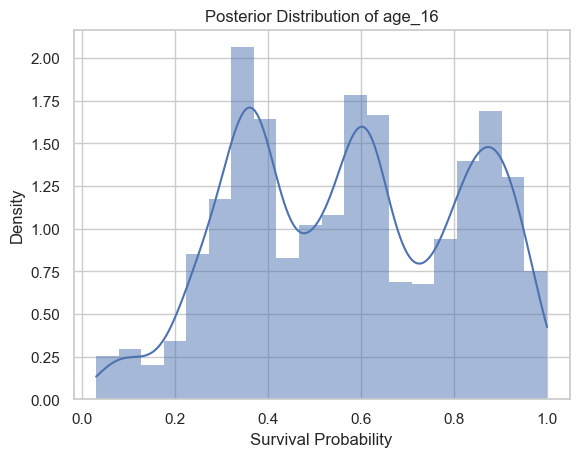

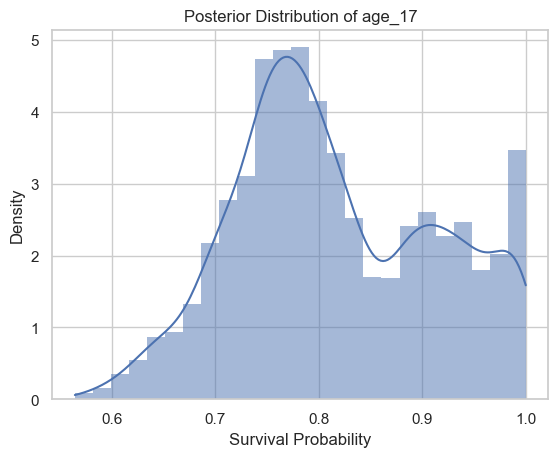

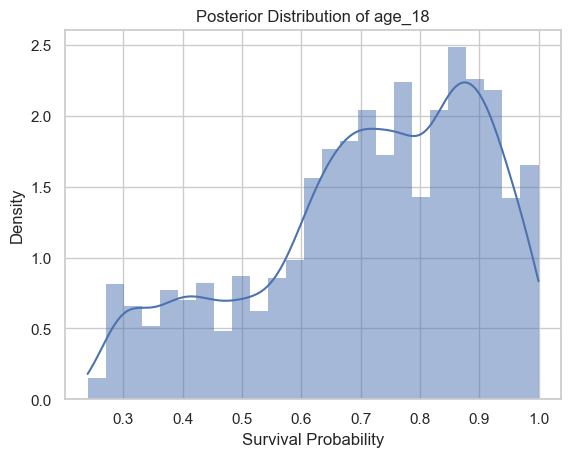

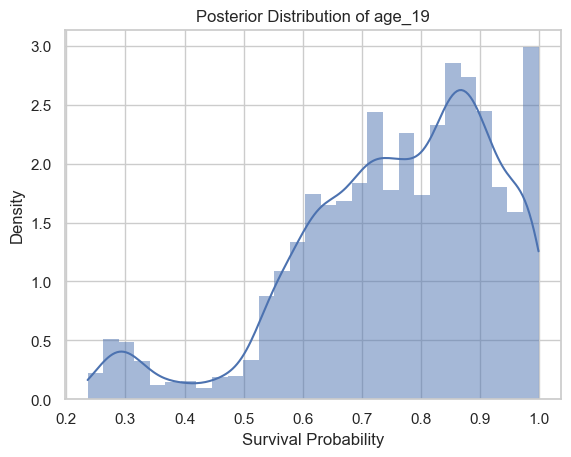

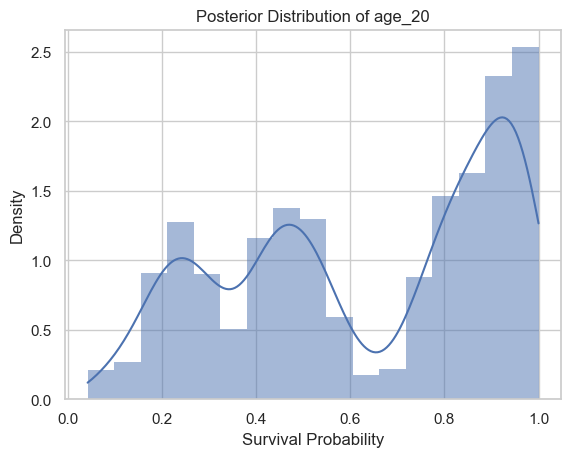

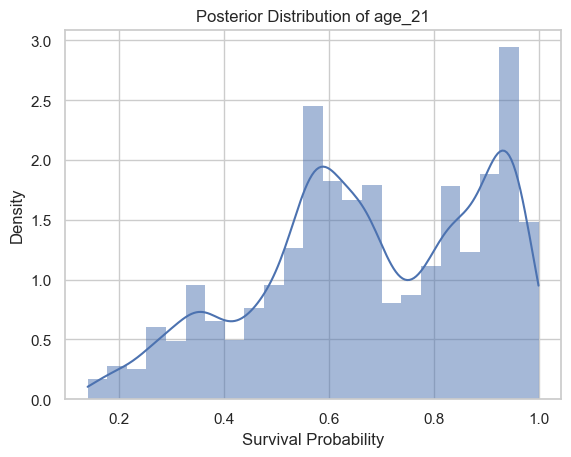

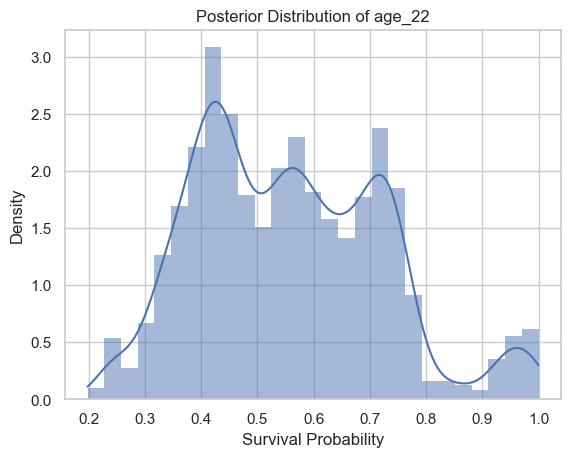

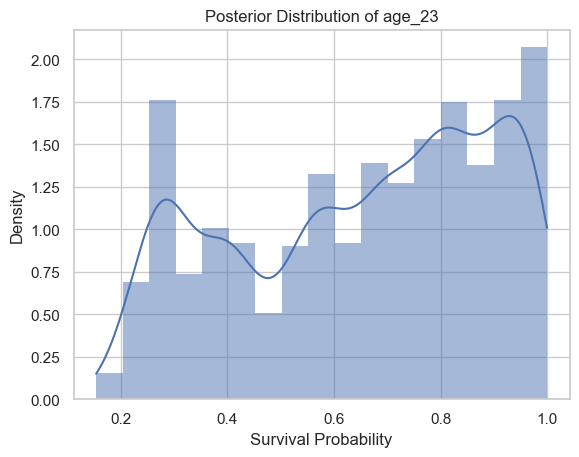

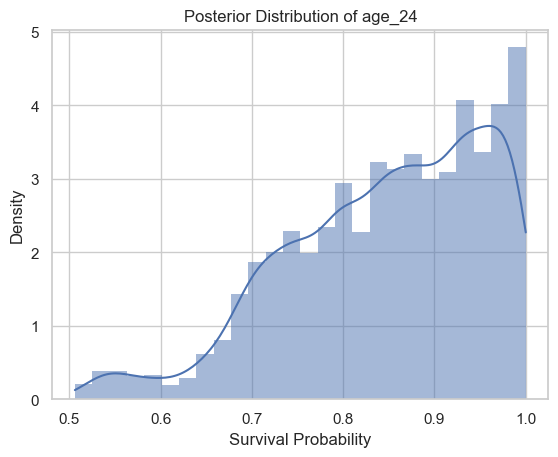

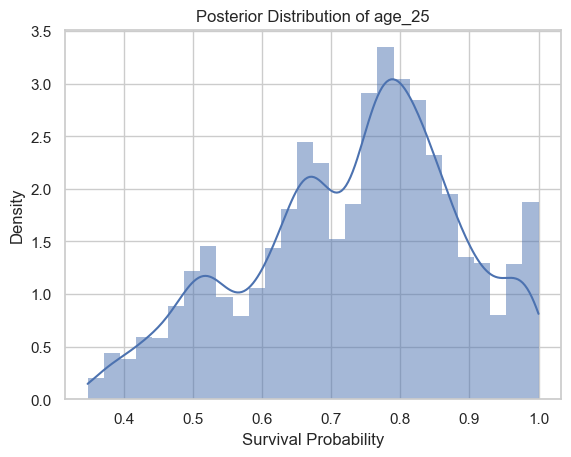

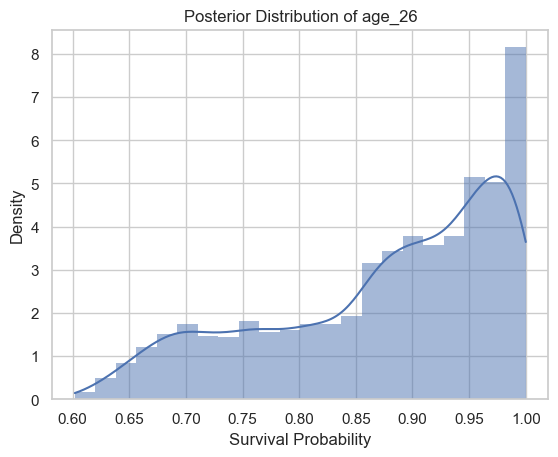

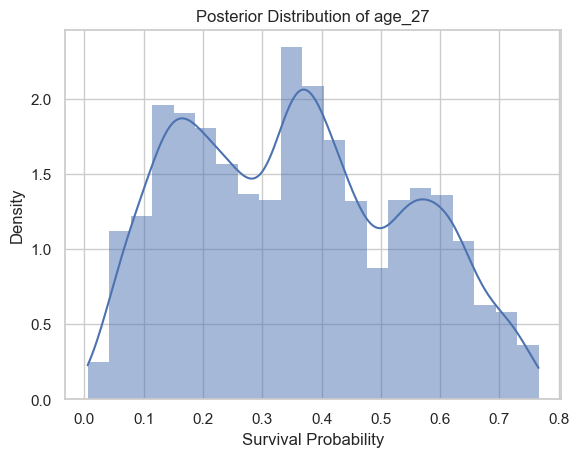

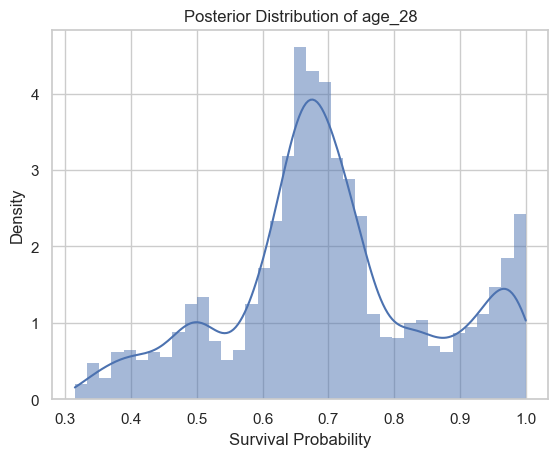

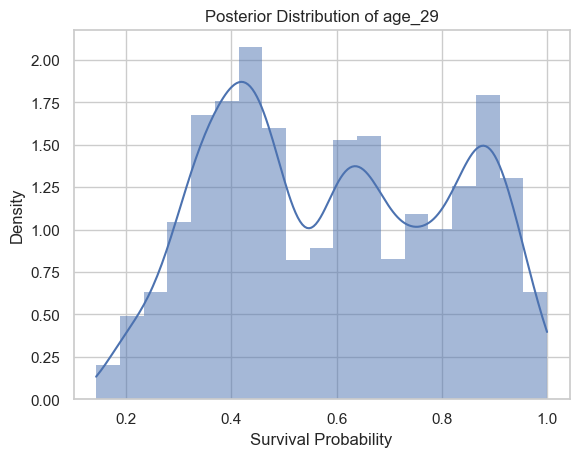

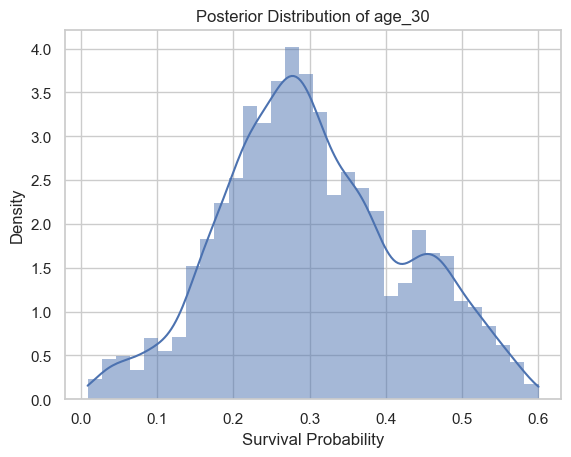

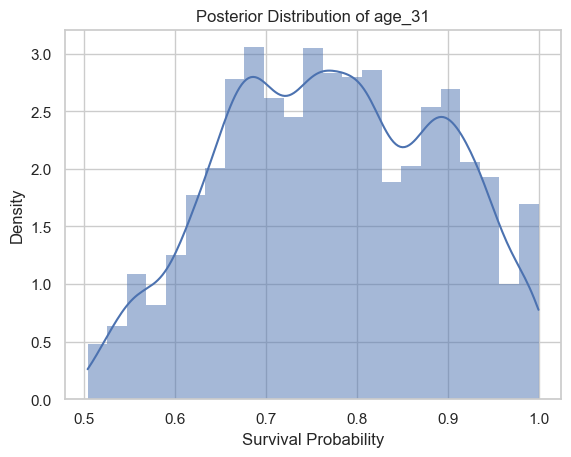

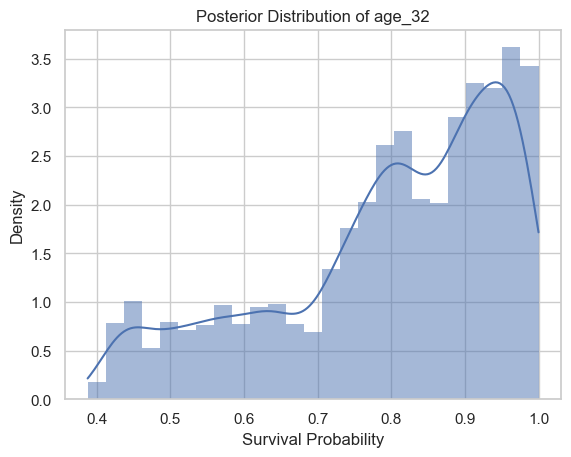

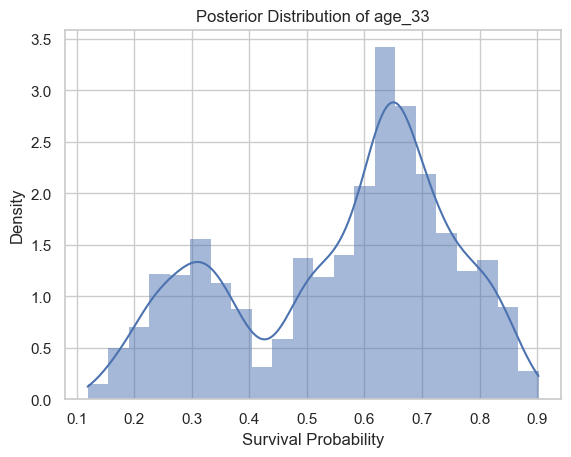

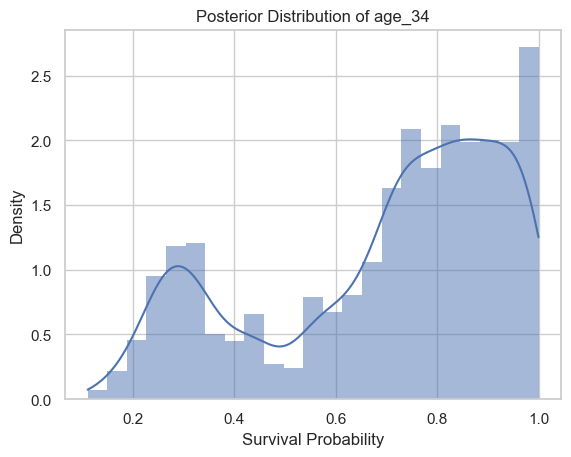

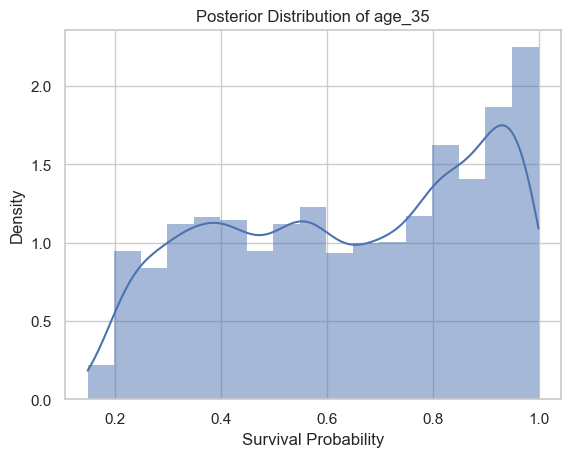

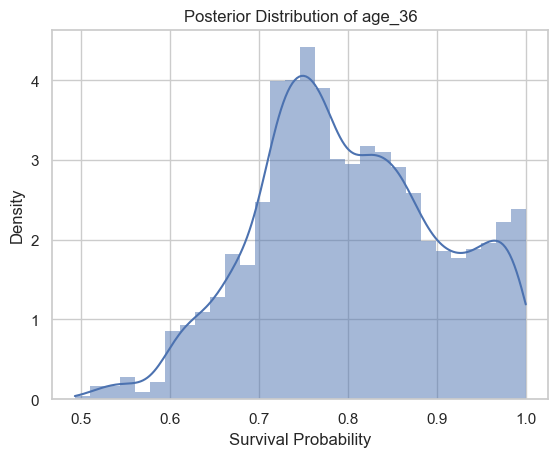

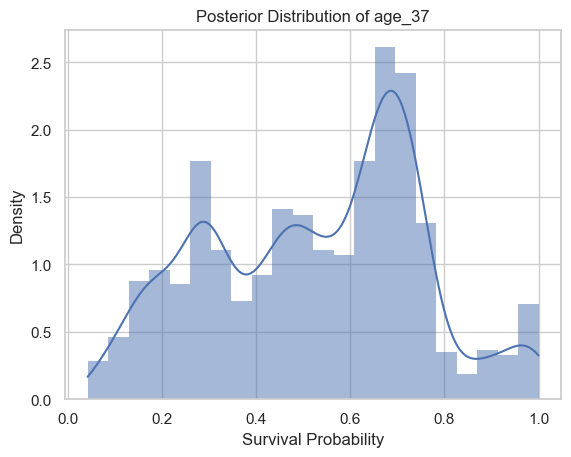

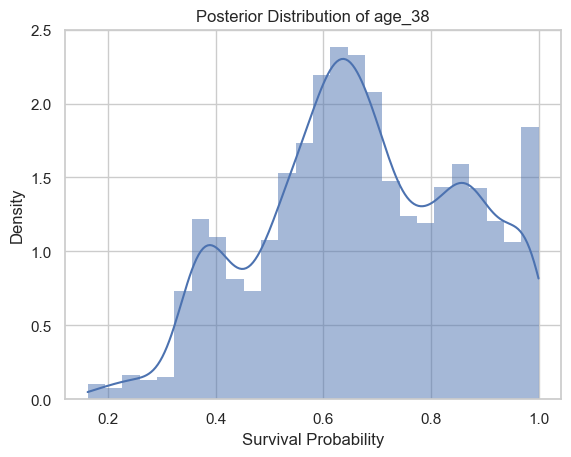

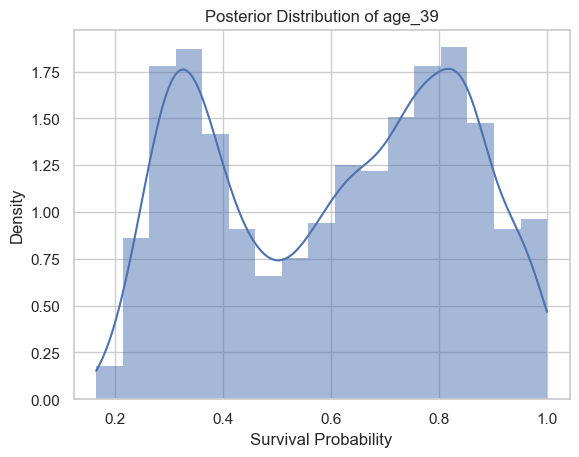

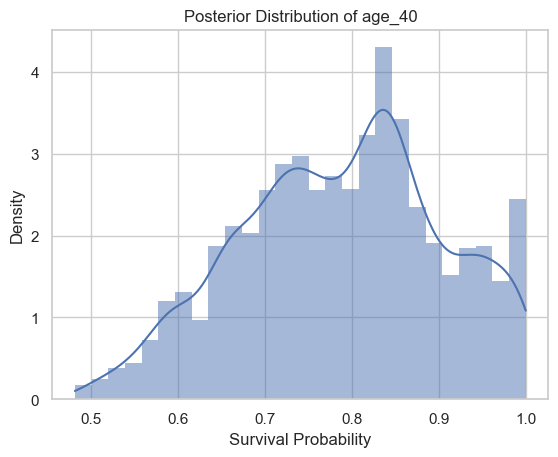

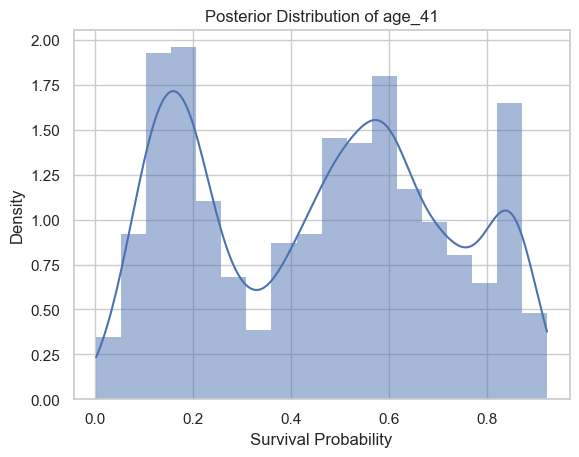

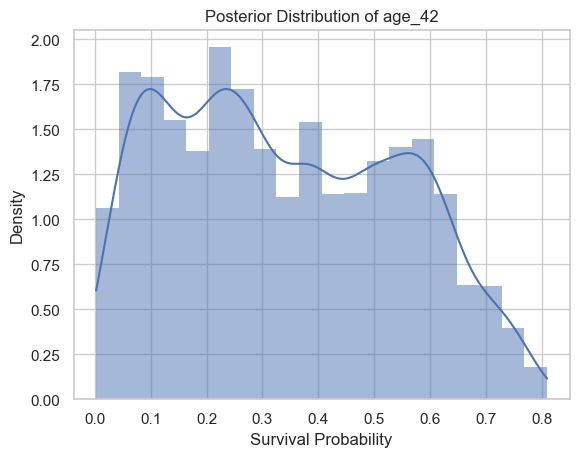

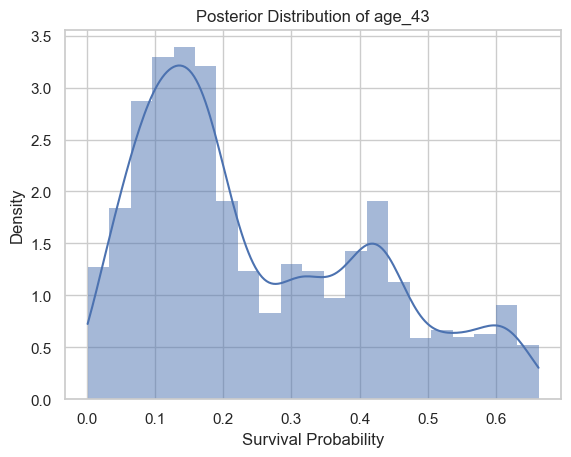

In [50]:
import pandas as pd

# Convert the samples to a DataFrame
# Assuming mcmc_samples is the output from your Metropolis MCMC
mcmc_df = pd.DataFrame(mcmc_samples, columns=[f'age_{age}' for age in life_table['age']])

# Plotting the posterior distributions
for column in mcmc_df:
    sns.histplot(mcmc_df[column], kde=True, stat="density", linewidth=0)
    plt.title(f'Posterior Distribution of {column}')
    plt.xlabel('Survival Probability')
    plt.ylabel('Density')
    plt.show()
